In [ ]:
# default_exp engine.gmm_loss

In [ ]:
%load_ext autoreload
%autoreload 2

# Loss function

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution

In [ ]:
#export
class PointProcessGaussian(Distribution):
    def __init__(self, logits: torch.tensor, xyzi_mu: torch.tensor, xyzi_sigma: torch.tensor, **kwargs):
        "logits: BS, C, H, W, D"
        self.logits = logits
        self.xyzi_mu = xyzi_mu
        self.xyzi_sigma = xyzi_sigma

    def log_prob(self, locations_3d, x_offset_3d, y_offset_3d, z_offset_3d, intensities_3d):
        
        batch_size = self.logits.shape[0]
        xyzi, s_mask = get_true_labels(batch_size, locations_3d, x_offset_3d, y_offset_3d, z_offset_3d, intensities_3d)
        counts = s_mask.sum(-1)
        
        P = torch.sigmoid(self.logits) # + 0.00001
        count_mean = P.sum(dim=[2, 3, 4]).squeeze(-1)
        count_var = (P - P ** 2).sum(dim=[2, 3, 4]).squeeze(-1) 
        count_dist = D.Normal(count_mean, torch.sqrt(count_var))
                
        count_prob =  count_dist.log_prob(counts) # * counts
        
        mixture_probs = P / P.sum(dim=[2, 3, 4], keepdim=True)
        
        pix_inds = torch.nonzero(P,as_tuple=True)

        xyzi_mu = self.xyzi_mu[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]]
        xyzi_mu[:,:3] += torch.stack([pix_inds[4],pix_inds[3],pix_inds[2]], 1) + 0.5

        xyzi_mu = xyzi_mu.reshape(batch_size,-1,4)
        xyzi_sig = self.xyzi_sigma[pix_inds[0],:,pix_inds[2],pix_inds[3],pix_inds[4]].reshape(batch_size,-1,4)

        mix = D.Categorical(mixture_probs[pix_inds].reshape(batch_size,-1))
        comp = D.Independent(D.Normal(xyzi_mu, xyzi_sig + 0.00001), 1)
        spatial_gmm = D.MixtureSameFamily(mix, comp)
        spatial_prob = spatial_gmm.log_prob(xyzi.transpose(0, 1)).transpose(0,1)
        spatial_prob = (spatial_prob * s_mask).sum(-1)
 
        return count_prob, spatial_prob

def get_sample_mask(bs, locations):
    
    counts_ = torch.unique(locations[0], return_counts=True)[1]
    batch_loc = torch.unique(locations[0])
    
    counts = torch.cuda.LongTensor(bs).fill_(0)
    counts[batch_loc] = counts_
    
    max_counts = counts.max()
    if max_counts==0: max_counts = 1 #if all 0 will return empty matrix of correct size
    s_arr = cum_count_per_group(locations[0])
    s_mask   = torch.cuda.FloatTensor(bs,max_counts).fill_(0)
    s_mask[locations[0],s_arr] = 1   
    
    return s_mask, s_arr
    
def get_true_labels(bs, locations, x_os, y_os, z_os, *args):
    
    s_mask, s_arr = get_sample_mask(bs, locations)
    max_counts = s_mask.shape[1]
    
    x =  x_os + locations[4].type(torch.cuda.FloatTensor) + 0.5 
    y =  y_os + locations[3].type(torch.cuda.FloatTensor) + 0.5 
    z =  z_os + locations[2].type(torch.cuda.FloatTensor) + 0.5 
    
    gt_vars = torch.stack([x, y, z] + [item for item in args], dim=1)
    gt_list = torch.cuda.FloatTensor(bs,max_counts,gt_vars.shape[1]).fill_(0)
    
    gt_list[locations[0],s_arr] = gt_vars
    return gt_list, s_mask

def grp_range(counts: torch.Tensor):
    assert counts.dim() == 1

    idx = counts.cumsum(0)
    id_arr = torch.ones(idx[-1], dtype=int, device=counts.device)
    id_arr[0] = 0
    id_arr[idx[:-1]] = -counts[:-1] + 1
    return id_arr.cumsum(0)

def cum_count_per_group(arr):
    """
    Helper function that returns the cumulative sum per group.
    Example:
        [0, 0, 0, 1, 2, 2, 0] --> [0, 1, 2, 0, 0, 1, 3]
    """

    if arr.numel() == 0:
        return arr

    _, cnt = torch.unique(arr, return_counts=True)
    return grp_range(cnt)[np.argsort(np.argsort(arr.cpu().numpy(), kind='mergesort'), kind='mergesort')]

In [ ]:
model_out = torch.load('../data/model_batch_output.pt')
model_out.keys()
model_out['logits'].shape

torch.Size([2, 1, 48, 48, 48])

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48])*.0001, sim_iters=5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
locs_3d = [l.cuda() for l in locs_3d]
xyzi_true, s_mask = get_true_labels(2, locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())
print(len(locs_3d[0]))
print(s_mask)
print(s_mask.sum(-1))

29
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.]],
       device='cuda:0')
tensor([16., 13.], device='cuda:0')


In [ ]:
gmm_loss = PointProcessGaussian(**model_out).log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())

(array([6., 3., 5., 4., 2., 3., 2., 1., 0., 3.]),
 array([0.64889324, 0.9456027 , 1.2423122 , 1.5390217 , 1.8357313 ,
        2.1324408 , 2.4291503 , 2.7258596 , 3.0225692 , 3.3192787 ,
        3.6159883 ], dtype=float32),
 <BarContainer object of 10 artists>)

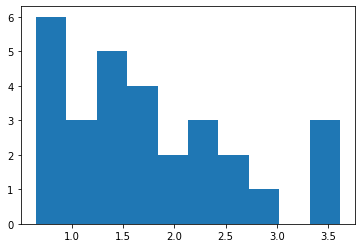

In [ ]:
plt.hist((ints_3d + 2).numpy())

In [ ]:
filt_gt_filt(ints_3d, 1, 1, 0.3)

tensor([ True, False, False, False,  True,  True, False,  True, False,  True,
         True,  True, False,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True])

In [ ]:
gmm_loss

(tensor([-5.8608e+17, -2.3596e+00], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-1074.2325, -1207.4500], device='cuda:0', grad_fn=<SumBackward1>))

In [ ]:
from decode_fish.funcs.utils import free_mem
free_mem()

In [ ]:
for i in range(1000):
    gmm_loss = PointProcessGaussian(**model_out).log_prob(locs_3d, x_os_3d.cuda(), y_os_3d.cuda(), z_os_3d.cuda(), ints_3d.cuda())

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
